In [1]:
# from pyspark import SparkContext 
# from pyspark.sql import SQLContext 
import pandas as pd
import numpy as np
# from pandas import DataFrame
# sc = SparkContext.getOrCreate()
# sqlc=SQLContext(sc)

import math
import matplotlib.pyplot as plt
from scipy.stats import norm, entropy 
from scipy.stats import probplot
import matplotlib.pyplot as plt
from scipy.stats import logistic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import resample
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from scipy.spatial.distance import cosine, correlation
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Perceptron

In [2]:
#reading csv file data in a dataframe
#[1]https://stackoverflow.com/questions/46311133/creating-dynamic-data-frames-in-python?rq=1
df_names=['df07','df08','df09','df10','df11','df12','df13','df14','df15','df16','df17','df18']
years=['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
d = {}
for name,i in zip(df_names,years):
    d[name] = pd.DataFrame()
    d[name]=pd.read_csv('data-csv/chs'+str(i)+'_public.csv')    


In [3]:
# df=df18.copy()
df=d['df14']
df.head()

,mood9,mood8,mood11,demog17,nutrition1,newrace,cid,survey,neighpovgroup4_0913,STRATA,...,maxdrinks14,maxdrinkscat_all,flag_imputed_pov200,imputed_pov200,flag_imputed_povertygroup,imputed_povertygroup,flag_imputed_povgroup3,imputed_povgroup3,hhsize,child
0,2.0,1.0,1.0,6.0,1.0,1,1500001,15,3.0,17,...,NaN,1.0,0,1,0,2,0,1,1,2.0
1,2.0,2.0,2.0,6.0,2.0,2,1500002,15,3.0,30,...,NaN,1.0,0,2,0,3,0,2,1,2.0
2,2.0,2.0,2.0,6.0,4.0,2,1500003,15,3.0,32,...,5.0,3.0,0,1,0,2,0,1,3,1.0
3,2.0,2.0,2.0,5.0,5.0,1,1500004,15,2.0,13,...,NaN,1.0,0,1,0,2,0,1,1,2.0
4,2.0,2.0,2.0,6.0,0.0,2,1500005,15,3.0,16,...,2.0,2.0,0,2,0,4,0,3,1,2.0


In [4]:
#number of features
len(df.columns)

175

In [5]:
df.columns

Index(['mood9', 'mood8', 'mood11', 'demog17', 'nutrition1', 'newrace', 'cid',
       'survey', 'neighpovgroup4_0913', 'STRATA',
       ...
       'maxdrinks14', 'maxdrinkscat_all', 'flag_imputed_pov200',
       'imputed_pov200', 'flag_imputed_povertygroup', 'imputed_povertygroup',
       'flag_imputed_povgroup3', 'imputed_povgroup3', 'hhsize', 'child'],
      dtype='object', length=175)

In [6]:
#number of rows
len(df["mood9"])

8562

In [7]:
df.isnull().sum()

mood9                      27
mood8                      26
mood11                     26
demog17                    49
nutrition1                236
                         ... 
imputed_povertygroup        0
flag_imputed_povgroup3      0
imputed_povgroup3           0
hhsize                      0
child                      27
Length: 175, dtype: int64

qxvers-Questionnaire version
nutrition46-cupsof fruit
nutrition47-cups of vegetable

# Steps followed for analysis
#process NA values
#find correlation between target and source variables and perform dimensionality reduction
#divide data into training and test sets
#apply regression
#reduce parameters depending upon correlartion
#apply regression again and compare models

In [8]:
#correlation function
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
#[2]https://seaborn.pydata.org/examples/many_pairwise_correlations.html
def draw_corr(corr_var):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_var, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(
        corr_var, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        mask=mask,
#         annot=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

# Checking correlation between physical activity data

In [9]:
df_train_physical=df[["cid","exercise14","generalhealth"]]

In [10]:
df_train_physical.isnull().sum()

cid               0
exercise14       14
generalhealth    62
dtype: int64

In [11]:
# #since imputed_PA08_3R_q1 has 5000+ values as N/A we will drop this column
# df_train_physical=df_train_physical[["cid","exercise116","cyclingfreq","cycling17","generalhealth"]]
# df_train_physical.head()

In [12]:
#dropping NaN values
df_train_physical=df_train_physical.dropna()
df_train_physical.head()

,cid,exercise14,generalhealth
0,1500001,1.0,4.0
1,1500002,1.0,3.0
2,1500003,1.0,3.0
3,1500004,2.0,4.0
4,1500005,2.0,3.0


In [13]:
#correlation
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
corr_1 = df_train_physical.corr()
corr_1

,cid,exercise14,generalhealth
cid,1.000000,-0.011321,-0.040961
exercise14,-0.011321,1.000000,0.222996
generalhealth,-0.040961,0.222996,1.000000


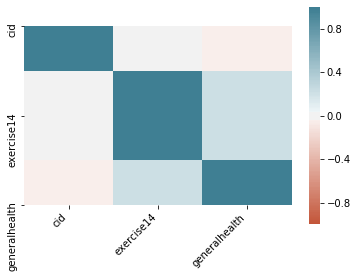

In [14]:
ax = sns.heatmap(
    corr_1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#we see that there is not much correlation among variables

In [15]:
# df_train_physical=df_train_physical[["cid","exercise17","cyclingfreq","generalhealth"]]
# df_train_physical.head()

In [16]:
# corr_2 = df_train_physical[["exercise17","cyclingfreq","generalhealth"]].corr()
# draw_corr(corr_2)
# print(corr_2)
# #All have positive correlation. exercise18 is most correlated to general health

# Checking correlation between Nutrition data

In [17]:
df_train_nutrition = df[["fruitveg",
                         "nsodaperday14","avgsodaperday14","twoplussoda",
                         "nsugardrinkperday14","avgsugarperday14","nsodasugarperday14",
                         "ssb",
                         "generalhealth"]]
print(df_train_nutrition.head())
df_train_nutrition.isnull().sum()


   fruitveg  nsodaperday14  avgsodaperday14  twoplussoda  nsugardrinkperday14  \
0       2.0            0.0              1.0          2.0                  0.0   
1       2.0            0.0              1.0          2.0                  0.0   
2       2.0            3.0              4.0          1.0                  0.0   
3       3.0            0.0              1.0          2.0                  0.0   
4       1.0            1.0              3.0          2.0                  0.0   

   avgsugarperday14  nsodasugarperday14  ssb  generalhealth  
0               1.0                 0.0  2.0            4.0  
1               1.0                 0.0  2.0            3.0  
2               1.0                 3.0  1.0            3.0  
3               1.0                 0.0  2.0            4.0  
4               1.0                 1.0  1.0            3.0  


fruitveg               236
nsodaperday14           63
avgsodaperday14         63
twoplussoda             63
nsugardrinkperday14    145
avgsugarperday14       145
nsodasugarperday14     120
ssb                    120
generalhealth           62
dtype: int64

avgsugarperday14  generalhealth       0.001552
generalhealth     avgsugarperday14    0.001552
avgsodaperday14   generalhealth       0.012365
generalhealth     avgsodaperday14     0.012365
twoplussoda       generalhealth       0.019076
                                        ...   
                  twoplussoda         1.000000
avgsodaperday14   avgsodaperday14     1.000000
nsodaperday14     nsodaperday14       1.000000
ssb               ssb                 1.000000
generalhealth     generalhealth       1.000000
Length: 81, dtype: float64

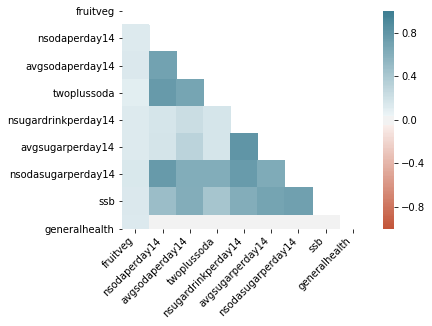

In [18]:
#[1]https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

df_train_nutrition=df_train_nutrition.dropna()
corr_3 = df_train_nutrition.corr().abs()
draw_corr(corr_3)

corr_3.unstack().sort_values(kind="quicksort")


generalhealth       avgsugarperday14      0.001552
avgsugarperday14    generalhealth         0.001552
generalhealth       avgsodaperday14       0.012365
avgsodaperday14     generalhealth         0.012365
generalhealth       nsodasugarperday14    0.034567
nsodasugarperday14  generalhealth         0.034567
ssb                 generalhealth         0.035331
generalhealth       ssb                   0.035331
avgsodaperday14     avgsugarperday14      0.313725
avgsugarperday14    avgsodaperday14       0.313725
ssb                 avgsodaperday14       0.614772
avgsodaperday14     ssb                   0.614772
nsodasugarperday14  avgsodaperday14       0.621510
avgsodaperday14     nsodasugarperday14    0.621510
avgsugarperday14    nsodasugarperday14    0.647118
nsodasugarperday14  avgsugarperday14      0.647118
ssb                 avgsugarperday14      0.692799
avgsugarperday14    ssb                   0.692799
ssb                 nsodasugarperday14    0.720283
nsodasugarperday14  ssb        

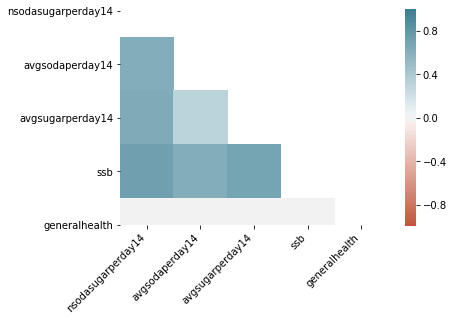

In [19]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[["nsodasugarperday14",
                        "avgsodaperday14"
                        ,"avgsugarperday14"
                         ,"ssb"
                         ,"generalhealth"]]

#finding correlation in remaining features
corr_nutrition = df_train_nutrition.corr().abs()
draw_corr(corr_nutrition)
corr_nutrition.unstack().sort_values(kind="quicksort")


#Next most correlated columns after deleting the previous coulmns:

nutrition47       fruitveg18          0.597664
fruitveg18        nutrition46         0.624137
avgsodaperday18   ssb                 0.626788

ssb               avgsugarperday18   -0.687271

ssb is correlated to both avgsodaperday18 and avgsugarperday18. We will keep ssb as it combines both soda and other drinks consumed by an individual. Also nutrition47 and fruitveg18 are correlated. Lets keep them for now as corelation is not very strong.

In [20]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[[
                         "ssb"
                         ,"generalhealth"]]

# Making prediction and checking rmse

In [21]:
#[1]https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
#[2]https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#[3]https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#[4]https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from math import sqrt

#function for rmse calculation of model
def model_apply(x,y,algo,n):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    scaler = StandardScaler()
    # Fit on training set only.
    scaler.fit(x_train)
    # Apply transform to both the training set and the test set.
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    pca = PCA(n_components=n,tol=.95)
    pca.fit(x_test)
    print(pca.explained_variance_ratio_) 
    
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    
#     principalDf = pd.DataFrame(data = x_train
#              , columns = ['pc1', 'pc2','pc3'])
#     print(principalDf)

    #model selection
    if algo==1:
        model=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=200)
    elif algo==2:
        model=GaussianNB()
    elif algo==3:
        model=DecisionTreeClassifier()
    elif algo==4:
        model=svm.SVC(gamma='scale')
    elif algo==5:
        model=Perceptron(tol=1e-3, random_state=0)
        
        # Train the model using the training sets
    model.fit(x_train,y_train.values.ravel())

    # Predict Output
    y_pred = model.predict(x_test)
    print ("Predicted Value:", y_pred)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return(rmse)

# Physical Activity vs General Health

In [22]:
#preparing training and test data
x=df_train_physical[["exercise14"]] #source feature
y=df_train_physical[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1888
# model = GaussianNB() #rmse=1.28

In [23]:
model_apply(x,y,1,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.31196983977379833
[[  0   0 377   0   0]
 [  0   0 576   0   0]
 [  0   0 662   0   0]
 [  0   0 371   0   0]
 [  0   0 136   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       377
         2.0       0.00      0.00      0.00       576
         3.0       0.31      1.00      0.48       662
         4.0       0.00      0.00      0.00       371
         5.0       0.00      0.00      0.00       136

    accuracy                           0.31      2122
   macro avg       0.06      0.20      0.10      2122
weighted avg       0.10      0.31      0.15      2122



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1888184679210374

# Nutrition vs General Health

In [24]:
#preparing training and test data
x=df_train_nutrition[["ssb"]] #source feature
y=df_train_nutrition[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1777
# model = GaussianNB() #rmse=1.28
model_apply(x,y,1,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.3141025641025641
[[  0   0 341   0   0]
 [  0   0 552   0   0]
 [  0   0 637   0   0]
 [  0   0 365   0   0]
 [  0   0 133   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       341
         2.0       0.00      0.00      0.00       552
         3.0       0.31      1.00      0.48       637
         4.0       0.00      0.00      0.00       365
         5.0       0.00      0.00      0.00       133

    accuracy                           0.31      2028
   macro avg       0.06      0.20      0.10      2028
weighted avg       0.10      0.31      0.15      2028



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1777439738118376

# Checking correlation between CardioVascular Health data

In [25]:
df_train_cardio=df[["toldhighbp14","toldprescription14","takingmeds14","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp14  toldprescription14  takingmeds14  generalhealth
0           1.0                 2.0           NaN            4.0
1           1.0                 1.0           1.0            3.0
2           2.0                 NaN           NaN            3.0
3           2.0                 NaN           NaN            4.0
4           1.0                 1.0           1.0            3.0


toldhighbp14            30
toldprescription14    5760
takingmeds14          6091
generalhealth           62
dtype: int64

toldprescription16 and takingmeds15 has high NA values so we have to drop them from dataset

In [26]:
df_train_cardio=df[["toldhighbp14","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp14  generalhealth
0           1.0            4.0
1           1.0            3.0
2           2.0            3.0
3           2.0            4.0
4           1.0            3.0


toldhighbp14     30
generalhealth    62
dtype: int64

toldhighbp14   generalhealth    0.312318
generalhealth  toldhighbp14     0.312318
toldhighbp14   toldhighbp14     1.000000
generalhealth  generalhealth    1.000000
dtype: float64

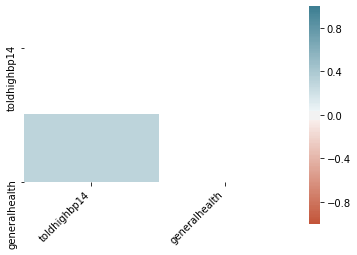

In [27]:
df_train_cardio=df_train_cardio.dropna()
corr_cardio = df_train_cardio.corr().abs()
draw_corr(corr_cardio)
corr_cardio.unstack().sort_values(kind="quicksort")

# Cardio vs General Health


In [50]:
df_train_cardio=df_train_cardio[["toldhighbp14","generalhealth"]]
df_train_cardio=df_train_cardio.dropna()
#preparing training and test data
x=df_train_cardio[["toldhighbp14"]] #source feature
y=df_train_cardio[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1768
# model = GaussianNB() #rmse=1.28
model_apply(x,y,1,1)

('Predicted Value:', array([3., 3., 3., ..., 3., 3., 3.]))
('Accuracy:', 0.32341831916902736)
[[  0   0 354   0   0]
 [  0   0 575   0   0]
 [  0   0 685   0   0]
 [  0   0 358   0   0]
 [  0   0 146   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       354
         2.0       0.00      0.00      0.00       575
         3.0       0.32      1.00      0.49       685
         4.0       0.00      0.00      0.00       358
         5.0       0.00      0.00      0.00       146

   micro avg       0.32      0.32      0.32      2118
   macro avg       0.06      0.20      0.10      2118
weighted avg       0.10      0.32      0.16      2118

1.17677397077


# Checking correlation between Diabetes data

In [28]:
df_train_diabetes=df[["diabetes14","generalhealth"]]
print(df_train_diabetes.head())
df_train_diabetes.isnull().sum()

   diabetes14  generalhealth
0         2.0            4.0
1         2.0            3.0
2         2.0            3.0
3         2.0            4.0
4         2.0            3.0


diabetes14       21
generalhealth    62
dtype: int64

Since only one column is there is no need to check correlation here.

# Diabetes vs General Health 

In [52]:
df_train_diabetes=df_train_diabetes[["diabetes14","generalhealth"]]
df_train_diabetes=df_train_diabetes.dropna()
#preparing training and test data
x=df_train_diabetes[["diabetes14"]] #source feature
y=df_train_diabetes[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1639
# algo=svm.SVC(gamma='scale') #emse=1.1714
# algo = GaussianNB() #rmse=1.2356
algo=DecisionTreeClassifier() #rmse=1.1714
model_apply(x,y,1,1)

('Predicted Value:', array([3., 3., 3., ..., 3., 4., 4.]))
('Accuracy:', 0.3273584905660377)
[[  0   0 350   9   0]
 [  0   0 510  35   0]
 [  0   0 620  84   0]
 [  0   0 298  74   0]
 [  0   0  73  67   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       359
         2.0       0.00      0.00      0.00       545
         3.0       0.33      0.88      0.49       704
         4.0       0.28      0.20      0.23       372
         5.0       0.00      0.00      0.00       140

   micro avg       0.33      0.33      0.33      2120
   macro avg       0.12      0.22      0.14      2120
weighted avg       0.16      0.33      0.20      2120

1.16392309932


# Clubbing the different parameters

In [29]:
#df_train_physical[["exercise17","cyclingfreq","generalhealth"]]
#df_train_diabetes[["diabetes17","generalhealth"]]
#df_train_cardio[["toldhighbp17","generalhealth"]]
#df_train_nutrition[["nutrition46","nutrition47","ssb"]]
df_clubbed=df[["cid","exercise14","ssb",
              "diabetes14","toldhighbp14","generalhealth"]]
print(df_clubbed.head())
df_clubbed.isnull().sum()

       cid  exercise14  ssb  diabetes14  toldhighbp14  generalhealth
0  1500001         1.0  2.0         2.0           1.0            4.0
1  1500002         1.0  2.0         2.0           1.0            3.0
2  1500003         1.0  1.0         2.0           2.0            3.0
3  1500004         2.0  2.0         2.0           2.0            4.0
4  1500005         2.0  1.0         2.0           1.0            3.0


cid                0
exercise14        14
ssb              120
diabetes14        21
toldhighbp14      30
generalhealth     62
dtype: int64

In [43]:
df_clubbed=df_clubbed.dropna()
#preparing training and test data
x=df_clubbed.drop(columns=["cid","generalhealth"]) #source feature
y=df_clubbed[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1661
# algo=svm.SVC(gamma='scale') #emse=1.1607
# algo = GaussianNB() #rmse=1.2136
# algo=DecisionTreeClassifier() #rmse=1.4525
model_apply(x,y,1,3)

[0.34327181 0.25498288 0.22531923]
Predicted Value: [3. 2. 2. ... 3. 2. 3.]
Accuracy: 0.3410182516810759
[[  0 220 134   4   0]
 [  0 279 253  18   0]
 [  0 272 363  65   0]
 [  0  72 209  68   0]
 [  0  18  62  45   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       358
         2.0       0.32      0.51      0.40       550
         3.0       0.36      0.52      0.42       700
         4.0       0.34      0.19      0.25       349
         5.0       0.00      0.00      0.00       125

    accuracy                           0.34      2082
   macro avg       0.20      0.24      0.21      2082
weighted avg       0.26      0.34      0.29      2082



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.074997486760684

# Physical Activity vs Cardio Health

In [55]:
#preparing training and test data
x=df_clubbed[["exercise14"]] #source feature
y=df_clubbed[["toldhighbp14"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5605
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.6858789625360231)
[[   0  654]
 [   0 1428]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       654
         2.0       0.69      1.00      0.81      1428

   micro avg       0.69      0.69      0.69      2082
   macro avg       0.34      0.50      0.41      2082
weighted avg       0.47      0.69      0.56      2082

0.560465018948


# Nutrition vs Cardio Health

In [56]:
#preparing training and test data
x=df_clubbed[["ssb"]] #source feature
y=df_clubbed[["toldhighbp14"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5605
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.6858789625360231)
[[   0  654]
 [   0 1428]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       654
         2.0       0.69      1.00      0.81      1428

   micro avg       0.69      0.69      0.69      2082
   macro avg       0.34      0.50      0.41      2082
weighted avg       0.47      0.69      0.56      2082

0.560465018948


# Physical vs Diabetes

In [57]:
#preparing training and test data
x=df_clubbed[["exercise14"]] #source feature
y=df_clubbed[["diabetes14"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3492
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.878001921229587)
[[   0  254]
 [   0 1828]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       254
         2.0       0.88      1.00      0.94      1828

   micro avg       0.88      0.88      0.88      2082
   macro avg       0.44      0.50      0.47      2082
weighted avg       0.77      0.88      0.82      2082

0.349282233688


# Nutrition vs Diabetes

In [58]:
#preparing training and test data
x=df_clubbed[["ssb"]] #source feature
y=df_clubbed[["diabetes14"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3493
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.878001921229587)
[[   0  254]
 [   0 1828]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       254
         2.0       0.88      1.00      0.94      1828

   micro avg       0.88      0.88      0.88      2082
   macro avg       0.44      0.50      0.47      2082
weighted avg       0.77      0.88      0.82      2082

0.349282233688


We observed that most of the Diabetes predictions are of class 2. Probably there is an imbalace of class in test data. Let us check.

# Resampling Diabetese Dataset

In [59]:
#[1]https://elitedatascience.com/imbalanced-classes
df_clubbed["diabetes14"].value_counts()

2.0    7295
1.0    1032
Name: diabetes14, dtype: int64

As we can see that class 2 has more samples than class 1 which shows that data is impbalanced and fovours class 2. Upsampling the class 1 data :

# Up Sampling

In [61]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_clubbed[df_clubbed.diabetes14==2]
df_minority = df_clubbed[df_clubbed.diabetes14==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=7925,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.diabetes14.value_counts()

1.0    7925
2.0    7295
Name: diabetes14, dtype: int64

# Nutrition vs Diabetes again after upsampling

In [62]:
#preparing training and test data
x=df_upsampled[["ssb"]] #source feature
y=df_upsampled[["diabetes14"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6629
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([1., 1., 1., ..., 1., 2., 1.]))
('Accuracy:', 0.5605781865965834)
[[1730  296]
 [1376  403]]
              precision    recall  f1-score   support

         1.0       0.56      0.85      0.67      2026
         2.0       0.58      0.23      0.33      1779

   micro avg       0.56      0.56      0.56      3805
   macro avg       0.57      0.54      0.50      3805
weighted avg       0.57      0.56      0.51      3805

0.662888990257


# Physical Activity vs Diabetes after upsampling

In [74]:
#preparing training and test data
x=df_upsampled[["exercise14"]] #source feature
y=df_upsampled[["diabetes14"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6753
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([1., 2., 2., ..., 1., 2., 2.]))
('Accuracy:', 0.5440210249671484)
[[ 694 1332]
 [ 403 1376]]
              precision    recall  f1-score   support

         1.0       0.63      0.34      0.44      2026
         2.0       0.51      0.77      0.61      1779

   micro avg       0.54      0.54      0.54      3805
   macro avg       0.57      0.56      0.53      3805
weighted avg       0.57      0.54      0.52      3805

0.675262152821


# Down Sampling

In [65]:
#Down Sampling
df_majority = df_clubbed[df_clubbed.diabetes14==2]
df_minority = df_clubbed[df_clubbed.diabetes14==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1032,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.diabetes14.value_counts()

1.0    1032
2.0    1032
Name: diabetes14, dtype: int64

# Nutrition vs Diabetes again after down sampling

In [66]:
#preparing training and test data
x=df_downsampled[["ssb"]] #source feature
y=df_downsampled[["diabetes14"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.7085
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 2.,
       1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 2., 2., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 1., 1., 1., 2., 2., 1., 1., 1., 2., 1., 1., 1., 2.,
       2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 2.,
       1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 2., 1., 1., 1., 1., 2., 1., 2., 2., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       2., 1., 2., 2., 1., 1., 2., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1.,
    

# Physical Activity vs Diabetes after down sampling

In [67]:
#preparing training and test data
x=df_downsampled[["exercise14"]] #source feature
y=df_downsampled[["diabetes14"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6197
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 1., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 2., 2., 2.,
       1., 2., 2., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 1., 2.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 1., 1., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1.,
       1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1., 1., 2., 1., 2., 2., 2.,
       1., 2., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       1., 2., 1., 2., 2., 2., 2., 2., 1., 2., 1., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1., 2., 1., 1., 2., 2., 2.,
       2., 2., 2., 1., 1., 2., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 2., 1., 2., 2., 2., 1., 2., 1., 2., 2., 1., 2., 2., 1., 2.,
       1., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1., 1.,
       1., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 1., 2., 1.,
    

After both Up and Down sampling the rmse is near about remains 0.66

# Marital Status vs Cardio Vascular Health

In [68]:
df_martial=df[["maritalstatus14","toldhighbp14","generalhealth"]]
df_martial=df_martial.dropna()

In [71]:
#preparing training and test data
x=df_martial[["maritalstatus14"]] #source feature
y=df_martial[["toldhighbp14"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5765
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([2., 2., 2., ..., 2., 2., 2.]))
('Accuracy:', 0.6676190476190477)
[[   0  698]
 [   0 1402]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       698
         2.0       0.67      1.00      0.80      1402

   micro avg       0.67      0.67      0.67      2100
   macro avg       0.33      0.50      0.40      2100
weighted avg       0.45      0.67      0.53      2100

0.576524893115


# Marital Status vs General Health Status

In [73]:
#preparing training and test data
x=df_martial[["maritalstatus14"]] #source feature
y=df_martial[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1765
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

('Predicted Value:', array([3., 3., 3., ..., 3., 3., 3.]))
('Accuracy:', 0.32571428571428573)
[[  0   0 379   0   0]
 [  0   0 546   0   0]
 [  0   0 684   0   0]
 [  0   0 373   0   0]
 [  0   0 118   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       379
         2.0       0.00      0.00      0.00       546
         3.0       0.33      1.00      0.49       684
         4.0       0.00      0.00      0.00       373
         5.0       0.00      0.00      0.00       118

   micro avg       0.33      0.33      0.33      2100
   macro avg       0.07      0.20      0.10      2100
weighted avg       0.11      0.33      0.16      2100

1.17655671954
